# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

> Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls. - [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html)

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

# train = pd.read_csv(train_url)
# test  = pd.read_csv(test_url)
train = pd.read_csv('datasets/food-inspections-train.csv')
test  = pd.read_csv('datasets/food-inspections-test.csv')

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

In [5]:
# Shallow tree
import category_encoders as ce
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier


def wrangle(df, clean_violations=True):
    df = df.copy()
    df = df.set_index('Inspection ID')
    df = df.drop(columns=[
        'Location', # redundant with 'Latitude', 'Longitude'
        'DBA Name', #  captures fewer unique values
        'AKA Name',
        'State', # homogenous
        'Facility Type', # too messy
        'Address',
        'License #',
        'Inspection Date'
    ])
    
    # fix city names
    df['City'] = df['City']
    chicago_names = ['chicagochicago', 'chicagohicago', 
                     'chchicago', 'cchicago', 'chicagoi']
    repl_dict = {chi:'chicago' for chi in chicago_names}
    df['City'] = (df['City'].str.lower()
                            .replace(repl_dict))
    
    # violations
    if clean_violations:
        df = handle_violations(df)
    else:
        df = df.drop(columns=['Violations'])
    
    df.loc[df['Latitude'].isna(), 'Latitude'] = df['Latitude'].mean()
    df.loc[df['Longitude'].isna(), 'Longitude'] = df['Longitude'].mean()
    df.loc[df['Zip'].isna(), 'Zip'] = df['Zip'].median()
    df = df.fillna('nan')

    return df


def handle_violations(df):
    df = df.copy()
    violations = df['Violations'].str.extractall(r'^([0-9]+)|(\| [0-9]+)')
    violations = (violations[0].fillna('') + 
                  violations[1].str.strip('| ').fillna(''))
    violations = violations.astype(int)
    all_violations = sorted(violations.unique())

    violations = pd.DataFrame(
        violations.reset_index().groupby('Inspection ID')[0].unique()
    )

    for x in all_violations:
        violations[f'violation_{x}'] = violations[0].apply(
            lambda row: x in row
        ).astype(int)

    violations = violations.drop(columns=[0])
    violations['n_violations'] = violations.sum(axis=1)
    df = df.drop(columns=['Violations'])
    df = df.merge(violations, how='left', left_index=True, 
                  right_index=True)
    # fill nans
    viol_cols = [col for col in df if 'violation' in col]
    df[viol_cols] = df[viol_cols].fillna(0)

    return df

In [6]:
train_clean = wrangle(train)

target_col = 'Fail'
# keep only violation features
X_train = train_clean[[col for col in train_clean if 'violation' in col]]
y_train = train_clean[target_col]

model = DecisionTreeClassifier(max_depth=2)

cross_val_score(model, X_train, y_train, cv=5, 
                scoring='roc_auc', n_jobs=-1)

array([0.7972313 , 0.78613708, 0.79528628, 0.78966841, 0.7901201 ])

The **violations** feature contains a data leak. We don't know what violations exist until we inspect the business.

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [7]:
target_col = 'Fail'

train_clean = wrangle(train, clean_violations=False)
X_train = train_clean.drop(columns=[target_col])
y_train = train_clean[target_col]

test_clean = wrangle(test, clean_violations=False)
X_test  = test_clean.drop(columns=[target_col])
y_test  = test_clean[target_col]

In [8]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    GradientBoostingClassifier()
)

cross_val_score(pipe, X_train, y_train, cv=3, scoring='roc_auc')

array([0.69131489, 0.69150376, 0.69610725])

In [9]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['Risk', 'City', 'Inspection Type'], drop_invariant=False,
        handle_unknown='impute', impute_missing=True,
        mapping=[{'col': 'Risk', 'mapping': [('Risk 1 (High)', 1), ('Risk 3 (Low)', 2), ('Risk 2 (Medium)', 3), ('nan', 4)]}, {'col': 'City',...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [10]:
y_predict = pipe.predict_proba(X_test)
roc_auc_score(y_test, [t[1] for t in y_predict])

0.6996897701925635

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

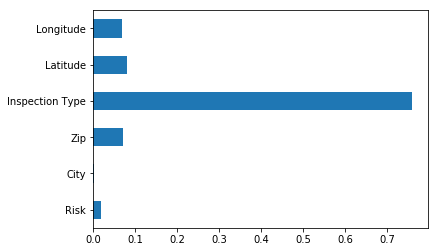

In [13]:
# feature importance
encoder = pipe.named_steps['ordinalencoder']
model = pipe.named_steps['gradientboostingclassifier']

X_train_transformed = encoder.transform(X_train)

pd.Series(model.feature_importances_,
          X_train_transformed.columns).plot.barh();

In [14]:
# permutation importance
import eli5
from eli5.sklearn import PermutationImportance

encoder = pipe.named_steps['ordinalencoder']
model = pipe.named_steps['gradientboostingclassifier']

X_train_transformed = encoder.transform(X_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train_transformed, y_train)

eli5.show_weights(permuter, top=None, 
                  feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.1630 ± 0.0000,Inspection Type
0.0178 ± 0.0000,Latitude
0.0169 ± 0.0000,Longitude
0.0132 ± 0.0000,Zip
0.0033 ± 0.0000,Risk
0.0003 ± 0.0000,City
